# Recurrent Neural Networks

In [1]:
!pip install -U gensim datasets

In [14]:
import tensorflow as tf # Biblioteca de deep learning
import gensim # Biblioteca de modelamiento de lenguaje
import datasets # Biblioteca de manejo de conjuntos de datos para procesamiento de lenguaje natural
import numpy as np # Biblioteca de manejo de datos vectoriales
import matplotlib.pyplot as plt # Biblioteca de visualización
import re

In [15]:
def normalize(text, remove_tildes = True):
    """Normaliza una cadena de texto convirtiéndo todo a minúsculas, quitando los caracteres no alfabéticos y los tildes"""
    text = text.lower() # Llevamos todo a minúscula
    text = re.sub(r'[^A-Za-zñáéíóú]', ' ', text) # Reemplazamos los caracteres no alfabéticos por un espacio
    if remove_tildes:
        text = re.sub('á', 'a', text) # Reemplazamos los tildes
        text = re.sub('é', 'e', text)
        text = re.sub('í', 'i', text)
        text = re.sub('ó', 'o', text)
        text = re.sub('ú', 'u', text)
    return text

Cargamos el conjunto de datos del curso.

In [3]:
spanish_diagnostics = datasets.load_dataset('fvillena/spanish_diagnostics') # Cargamos las particiones de entrenamiento y prueba

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spanish_diagnostics.py:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/3.27M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/70000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Cargamos los embedding clínicos.

In [6]:
import ssl
import urllib
ssl._create_default_https_context = ssl._create_unverified_context
urllib.request.urlretrieve("https://zenodo.org/record/3924799/files/cwlce.vec", "cwlce.vec") #Descargamos los embedding clinicos calculados por PLN@CMM

('cwlce.vec', <http.client.HTTPMessage at 0x7bba44e18510>)

In [9]:
cwlce = gensim.models.KeyedVectors.load_word2vec_format("cwlce.vec")

Extraemos el vocabulario desde nuestro modelo.


In [10]:
vocab = cwlce.index_to_key

In [11]:
len(vocab)

57112

## Preprocesamiento

Normalizamos el corpus.

In [16]:
spanish_diagnostics_normalized = spanish_diagnostics.map(
    lambda x: {
        "normalized_text" : normalize(x["text"])
    })

Map:   0%|          | 0/70000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Para poder pasar nuestros documentos por la red neuronal, cada uno debe ser convertido a una secuencia de índices de palabras del vocabulario. Además, debemos asegurarnos que cada una de las secuencias que utilizaremos para entrenar el modelo tiene el mismo largo.

Primero tokenizamos el texto crudo.

In [17]:
document = spanish_diagnostics_normalized["train"]["normalized_text"][0]
document

'  anomalias dentofaciales  incluso la maloclusion     discrepancia dentomaxilar'

In [18]:
tokens = tf.keras.preprocessing.text.text_to_word_sequence(document)
tokens

['anomalias',
 'dentofaciales',
 'incluso',
 'la',
 'maloclusion',
 'discrepancia',
 'dentomaxilar']

Convertimos esta lista de tokens en una lista de índices de palabras respecto al vocabulario, sólo si esta palabra está en el vocabulario.

In [19]:
sequence = [vocab.index(word) for word in tokens if word in vocab]
sequence

[76, 123, 131, 3, 83, 2552, 737]

Finalmente agregamos ceros al principio de nuestra secuencia para que todas tengan exactamente el mismo largo.

In [20]:
padded_sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], maxlen=20)
padded_sequence

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   76,  123,  131,    3,   83, 2552,  737]],
      dtype=int32)

Consolidamos todo en una función.

In [21]:
def text_to_sequence(text,vocab):
  """Esta función recibe una lista de strings y devuelve una lista de listas de índices del vocabulario"""
  sequences = []
  tokens = tf.keras.preprocessing.text.text_to_word_sequence(text)
  sequence = [vocab.index(word) for word in tokens if word in vocab]
  sequences.append(sequence)
  return sequences

In [22]:
def encode_text(text,vocab,maxlen=20):
  """Esta función recibe string y devuelve una lista de índices del vocabulario con padding"""
  sequences = text_to_sequence(text,vocab)
  padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)
  return padded_sequences[0]

Verificamos cómo funciona nuestra función.

In [23]:
encode_text("cancer    de colon",vocab)

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0, 192,   1, 235], dtype=int32)

Aplicamos nuestra función a todo el corpus.

In [24]:
spanish_diagnostics_normalized_encoded = spanish_diagnostics_normalized.map(
    lambda x: {
        "encoded_text" : encode_text(x["normalized_text"],vocab)
    })

Map:   0%|          | 0/70000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Así se ve una instancia de nuestro dataset.

In [25]:
spanish_diagnostics_normalized_encoded["train"][0]

{'text': '- ANOMALÍAS DENTOFACIALES (INCLUSO LA MALOCLUSIÓN)\n\n\n DISCREPANCIA DENTOMAXILAR',
 'label': 1,
 'normalized_text': '  anomalias dentofaciales  incluso la maloclusion     discrepancia dentomaxilar',
 'encoded_text': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  76,
  123,
  131,
  3,
  83,
  2552,
  737]}

## Modelamiento

El primer paso del modelamiento es declarar la arquitectura que tendrá nuestra red neuronal. El tipo de red neuronal más utilizado para resolver tareas relacionadas con textos son las redes neuronales recurrentes.

En este caso diseñaremos una red neuronal recurrente simple en donde cada una de las celdas de la red neuronal toma como entrada la salida del paso anterior en la secuencia.

La primera capa de nuestra arquitectura será la representación de cada una de las palabras del corpus a través de un embedding. Esta capa representará la secuencia de índices como una secuencia de embeddings asociados a cada palabra del vocabulario.

Esta secuencia de embeddings se pasará de manera serial por la capa recurrente simple y el estado oculto asociado al último paso de la secuencia será la representación asociada a la secuencia completa.

Esta representación de la secuencia entrará a la última capa densa que contiene sólo una neurona que representará la salida verdadera o falsa de nuestra red.

Especificamente en esta instancia compararemos los rendimientos de esta arquitectura al inicializar la capa de embedding con valores al azar y al inicializar la capa de embedding con valores preentrenados. También cada modelo tendrá una versión en donde sí estamos ajustando los embedding y donde no estamos ajustando los embedding.

In [26]:
def make_model(embedding,trainable_embeddings,vocab):
  """Con esta función instanciamos la arquitectura de red neuronal recurrente."""
  model = tf.keras.Sequential() # La declaración de la arquitectura se hará de manera secuencial. La salida de la capa será la entrada de la capa siguiente.
  if embedding == "random": # La capa de embedding estará condicionada con esto.
    embedding_layer = tf.keras.layers.Embedding( # Esta capa de embedding se inicializará con valores al azar.
        input_dim=len(vocab), # La cantidad de embeddings (filas) será igual al tamaño del vocabulario.
        output_dim=300, # Cada palabra se representará con 300 dimensiones-
        trainable=trainable_embeddings, # Con esto declaramos si se ajustará o no la capa de embedding.
        mask_zero=True # Con esto omitimos pasar a la siguiente capa la representación del padding.
    )
  else:
    embedding_layer = tf.keras.layers.Embedding(
        input_dim=len(vocab),
        output_dim=embedding.vectors.shape[1],
        trainable=trainable_embeddings,
        weights=[embedding.vectors], # Inicializamos la capa de embedding con los embedding preentrenados.
        mask_zero=True
    )
  model.add(embedding_layer) # Agregamos la capa de embedding a la arquitectura
  model.add(tf.keras.layers.SimpleRNN( # Agregamos la capa recurrente a la arquitectura
      128, # La salida de esta capa tendrá 128 dimensiones
      recurrent_dropout=0.2)) # Al azar cambia por 0 el 30 % de los pesos con el fin de disminuir el sobreajuste.
  model.add(tf.keras.layers.Dropout(0.3)) # Esta capa al azar cambia por 0 el 30 % de los pesos con el fin de disminuir el sobreajuste.
  model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # Esta es la capa de clasificación binaria.
  model.compile( # Compilamos el modelo
      loss='binary_crossentropy', # Utilizamos entropia cruzada binaria debido a la que la capa de clasificación es binaria
      optimizer='adam', # Usamos ADAM como optimización, un descenso de gradientes "inteligente".
      metrics=['accuracy']) # Medimos el rendimiento de la clasificación con accuracy debido a que nuestras clases están balanceadas.
  return model

In [27]:
spanish_diagnostics_normalized_encoded.set_format(type="numpy", columns=["encoded_text","label"]) # transformamos las características a arreglos de numpy

Una de las técnicas para hacer el entrenamiento de la red más corto detenemos el entrenamiento si la métrica objetivo no mejora al avanzar las épocas. Esta técnica se llama Early Stopping.

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping( # Instanciamos un objeto de Early Stopping para detener el entrenamiento si no seguimos aprendiendo
    monitor='val_accuracy', # Monitoreamos el accuracy del conjunto de validación
    patience=2, # Si por 2 épocas seguidas no aumentamos el accuracy, detenemos el entrenamiento
    restore_best_weights=True, # Cuando detenemos el entrenamiento restablecemos los pesos con el mejor rendimiento.
    verbose=True
)

### Entrenamiento

Entrenaremos 4 modelos distintos y compararemos sus resultados:

1.   Modelo utilizando embeddings preentrenados y además ajustándolos en el entrenamiento.
2.   Modelo utilizando embeddings preentrenados y sin ajustarlos en el entrenamiento.
3.   Modelo sin utilizar embeddings preentrenados, sólo ajustándolos en el entrenamiento.
4.   Modelo sin utilizar embeddings preentrenados y sin ajustarlos en el entrenamiento.


#### Embeddings clínicos preentrenados con ajuste en el entrenamiento.

Utilizaremos los embeddings preentrenados en un corpus clínico y además los ajustaremos para resolver la tarea de clasificación

In [29]:
model_cwlce_trainable = make_model( # Instanciamos nuestro modelo
    embedding = cwlce, # Usamos los embeddings preentrenados
    trainable_embeddings = True, # Ajustamos los modelos en el entrenamiento
    vocab = vocab # Usamos el vocabulario de los embeddings
)
model_cwlce_trainable_hist = model_cwlce_trainable.fit( # Ajustamos el modelo
    spanish_diagnostics_normalized_encoded["train"]["encoded_text"][:7000], # Utilizamos el 10% de los datos de entrenamiento
    spanish_diagnostics_normalized_encoded["train"]["label"][:7000],
    epochs=10, # Entrenamos máximo por 10 épocas
    # callbacks=[early_stopping], # Llamamos a nuestro objeto de Early Stopping al final de cada época
    validation_data=( # Utilizamos el conjunto de prueba para validar el modelo al final de cada época.
        spanish_diagnostics_normalized_encoded["test"]["encoded_text"][:3000],
        spanish_diagnostics_normalized_encoded["test"]["label"][:3000],
    )
)

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.8687 - loss: 0.3128 - val_accuracy: 0.9573 - val_loss: 0.1484
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9588 - loss: 0.1431 - val_accuracy: 0.9593 - val_loss: 0.1374
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9692 - loss: 0.1110 - val_accuracy: 0.9520 - val_loss: 0.1510
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9766 - loss: 0.0801 - val_accuracy: 0.9520 - val_loss: 0.1567
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9785 - loss: 0.0623 - val_accuracy: 0.9480 - val_loss: 0.1889
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9846 - loss: 0.0490 - val_accuracy: 0.9477 - val_loss: 0.2080
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9889 - loss: 0.0322 - val_accuracy: 0.9427 - val_loss: 0.2270
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9875 - loss: 0.0382 - val_accuracy: 0

#### Embeddings clínicos preentrenados sin ajuste en el entrenamiento.

Utilizaremos los embeddings preentrenados en un corpus clínico y no los ajustaremos al resolver la tarea de clasificación.

In [30]:
model_cwlce_frozen = make_model(
    embedding = cwlce,
    trainable_embeddings = False, # No ajustamos los modelos en el entrenamiento
    vocab = vocab
)
model_cwlce_frozen_hist = model_cwlce_frozen.fit(
    spanish_diagnostics_normalized_encoded["train"]["encoded_text"][:7000],
    spanish_diagnostics_normalized_encoded["train"]["label"][:7000],
    epochs=10,
    # callbacks=[early_stopping],
    validation_data=(
        spanish_diagnostics_normalized_encoded["test"]["encoded_text"][:3000],
        spanish_diagnostics_normalized_encoded["test"]["label"][:3000],
    )
)

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8724 - loss: 0.3041 - val_accuracy: 0.9583 - val_loss: 0.1631
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9543 - loss: 0.1620 - val_accuracy: 0.9577 - val_loss: 0.1433
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9529 - loss: 0.1624 - val_accuracy: 0.9597 - val_loss: 0.1461
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9570 - loss: 0.1490 - val_accuracy: 0.9553 - val_loss: 0.1462
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9620 - loss: 0.1287 - val_accuracy: 0.9580 - val_loss: 0.1412
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9670 - loss: 0.1117 - val_accuracy: 0.9583 - val_loss: 0.1493
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9660 - loss: 0.1142 - val_accuracy: 0.9557 - val_loss: 0.1506
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9700 - loss: 0.1000 - val_accuracy: 

#### Los embeddings se ajustan en el entrenamiento

No utilizaremos los embeddings preentrenados, los ajustaremos mientras se resuelve la tarea de clasificación

In [31]:
model_random_trainable = make_model(
    embedding = "random", # No usamos embeddings preentrenados.
    trainable_embeddings = True,
    vocab = vocab
)
model_random_trainable_hist = model_random_trainable.fit(
    spanish_diagnostics_normalized_encoded["train"]["encoded_text"][:7000],
    spanish_diagnostics_normalized_encoded["train"]["label"][:7000],
    epochs=10,
    # callbacks=[early_stopping],
    validation_data=(
        spanish_diagnostics_normalized_encoded["test"]["encoded_text"][:3000],
        spanish_diagnostics_normalized_encoded["test"]["label"][:3000],
    )
)

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.7777 - loss: 0.4689 - val_accuracy: 0.9417 - val_loss: 0.1858
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9591 - loss: 0.1444 - val_accuracy: 0.9393 - val_loss: 0.1845
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9763 - loss: 0.0774 - val_accuracy: 0.9380 - val_loss: 0.2192
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9860 - loss: 0.0504 - val_accuracy: 0.9303 - val_loss: 0.2569
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9876 - loss: 0.0411 - val_accuracy: 0.9323 - val_loss: 0.2605
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9913 - loss: 0.0290 - val_accuracy: 0.9253 - val_loss: 0.2518
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9898 - loss: 0.0279 - val_accuracy: 0.9273 - val_loss: 0.2785
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9933 - loss: 0.0196 - val_accuracy: 

#### Los embeddings no se ajustan en el entrenamiento ni se preentrenan

No utilizaremos los embeddings preentrenados ni los ajustaremos mientras se resuelve la tarea de clasificación

In [32]:
model_random_frozen = make_model(
    embedding = "random",
    trainable_embeddings = False,
    vocab = vocab
)
model_random_frozen_hist = model_random_frozen.fit(
    spanish_diagnostics_normalized_encoded["train"]["encoded_text"][:7000],
    spanish_diagnostics_normalized_encoded["train"]["label"][:7000],
    epochs=10,
    # callbacks=[early_stopping],
    validation_data=(
        spanish_diagnostics_normalized_encoded["test"]["encoded_text"][:3000],
        spanish_diagnostics_normalized_encoded["test"]["label"][:3000],
    )
)

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.6393 - loss: 0.6505 - val_accuracy: 0.7963 - val_loss: 0.5355
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7692 - loss: 0.5525 - val_accuracy: 0.7773 - val_loss: 0.5421
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7895 - loss: 0.5212 - val_accuracy: 0.8213 - val_loss: 0.4873
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8031 - loss: 0.4775 - val_accuracy: 0.8083 - val_loss: 0.4498
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8166 - loss: 0.4618 - val_accuracy: 0.8157 - val_loss: 0.4371
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8118 - loss: 0.4684 - val_accuracy: 0.7913 - val_loss: 0.4516
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7642 - loss: 0.5037 - val_accuracy: 0.6253 - val_loss: 0.6109
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6916 - loss: 0.5919 - val_accuracy: 0

### Comparación

Compararemos cómo se van comportando las métricas objetivo a medida que avanzaron las épocas.

Los modelos que usaron embeddings preentrenados obtuvieron el mejor rendimiento y al ajustar esos embeddings preentrenados obtenemos un mejor rendimiento.

El ajustar los embeddings sin preentrenarlos también genera buenos resultados, pero el nunca ajustar los embeddings genera muy malos resultados porque no tenemos un modelo lo suficientemente flexible para ajustarse a resolver la tarea.

Se debe destacar que el no ajustar los embeddings en el entrenamiento genera un aumento significativo en la velocidad de entrenamiento.

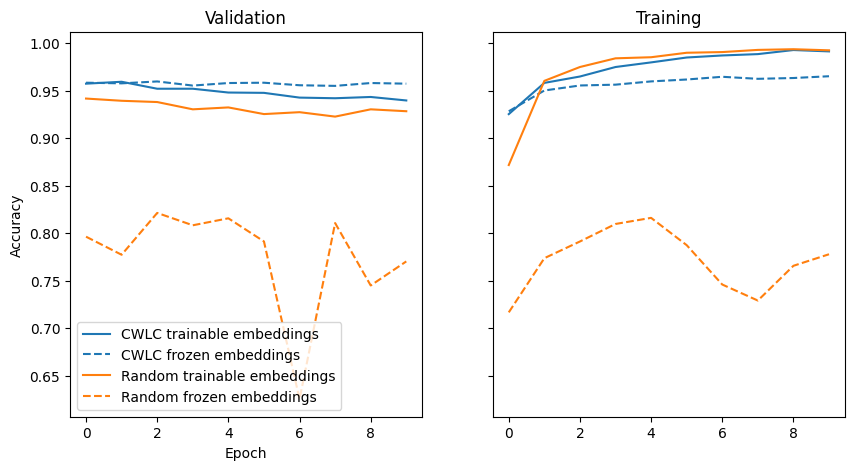

In [33]:
fig, axs = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)

axs[0].plot(
    model_cwlce_trainable_hist.history["val_accuracy"],
    c="tab:blue",
    label="CWLC trainable embeddings"
)
axs[0].plot(
    model_cwlce_frozen_hist.history["val_accuracy"],
    c="tab:blue",
    linestyle="--",
    label="CWLC frozen embeddings"
)

axs[0].plot(
    model_random_trainable_hist.history["val_accuracy"],
    c="tab:orange",
    label="Random trainable embeddings"
)
axs[0].plot(
    model_random_frozen_hist.history["val_accuracy"],
    c="tab:orange",
    linestyle="--",
    label="Random frozen embeddings"
)


axs[1].plot(
    model_cwlce_trainable_hist.history["accuracy"],
    c="tab:blue",
    label="CWLC trainable embeddings"
)
axs[1].plot(
    model_cwlce_frozen_hist.history["accuracy"],
    c="tab:blue",
    linestyle="--",
    label="CWLC frozen embeddings"
)

axs[1].plot(
    model_random_trainable_hist.history["accuracy"],
    c="tab:orange",
    label="Random trainable embeddings"
)
axs[1].plot(
    model_random_frozen_hist.history["accuracy"],
    c="tab:orange",
    linestyle="--",
    label="Random frozen embeddings"
)
axs[0].legend()
axs[0].set_title("Validation")
axs[1].set_title("Training")
axs[0].set_ylabel("Accuracy")
axs[0].set_xlabel("Epoch")
plt.show()

Probemos qué predice la red al pasar un ejemplo del conjunto de prueba.

In [34]:
spanish_diagnostics["test"]["text"][2]

'N913 OLIGOMENORREA PRIMARIA AMENORREA PRIMARIA NUNCA ESTUDIADA SOLICITO CARIPOGRAMA ADEMAS HIPOTIROIDISMO DESDE LOS 18 AÑOS EN TRATAMIENTO'

In [35]:
spanish_diagnostics_normalized_encoded["test"]["encoded_text"][2]

array([    0,     0,     0,     0,    49,  4698,   347,  1076,   347,
        3285,  5249,   269, 40362,  1195,   254,   440,     8,    94,
           6,   141])

In [36]:
example_input = np.expand_dims(spanish_diagnostics_normalized_encoded["test"]["encoded_text"][2], axis=0)

La salida de la red es un número menor a 0.5 por lo que podemos asumir que es de la clase False, por lo que la clase predecida es no_dental.

In [37]:
model_cwlce_trainable.predict(example_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


array([[0.00100142]], dtype=float32)

## Exploración en detalle de la arquitectura.

Tenemos esencialmente una arquitectura de 3 capas (omitimos el dropout):

*   Capa de embedding con 17.133.600 parametros entrenables. Esta cantidad se explica porque tenemos 300 parámetros por cada una de las 57112 palabras del vocabulario.
*   Capa recurrente con 54.910 parámetros explicados porque tenemos `128*300` pesos para representar las 300 activaciones de entrada con 128 unidades por cada celda de la red, `128*128` pesos para representar el estado oculto de cada célula y 128 biases que se suman al estado oculto.
* Capa de clasificación con `1*128` pesos para representar la única neurona de clasificación, además de su respectivo 1 bias.



In [38]:
model_cwlce_trainable.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 20, 300)        │    17,133,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        54,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,565,925 (196.71 MB)

 Trainable params: 17,188,641 (65.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,377,284 (131.14 MB)

Exploraremos cómo pasar manualmente nuestro ejemplo por la red.

Primero debemos representar nuestra secuencia de entrada con los embeddings de la red. Nuestra capa de embedding es simplemente un mapeo desde los índices de nuestro vocabulario hacia los embeddings de cada palabra, por lo que podemos extraer los embeddings simplemente mediante una lista de índices.

La salida de esta capa debiese ser una secuencia de embeddings del mismo tamaño que la entrada (20), además tenemos una dimensión adicional al principio que es batch size, el cual es 1, porque sólo tenemos 1 ejemplo.

Además de la secuencia de embedding debemos tener una máscara que nos dirá qué embeddings omitir. Debemos omitir todos los embeddings que son parte del padding.

In [39]:
example_embedding_sequence = tf.gather(
    model_cwlce_trainable.layers[0].weights[0],
    indices=example_input
    )
example_embedding_sequence

<tf.Tensor: shape=(1, 20, 300), dtype=float32, numpy=
array([[[ 1.33400003e-03,  1.47300004e-03, -1.27699994e-03, ...,
         -4.37000010e-04, -5.52000012e-04,  1.02400000e-03],
        [ 1.33400003e-03,  1.47300004e-03, -1.27699994e-03, ...,
         -4.37000010e-04, -5.52000012e-04,  1.02400000e-03],
        [ 1.33400003e-03,  1.47300004e-03, -1.27699994e-03, ...,
         -4.37000010e-04, -5.52000012e-04,  1.02400000e-03],
        ...,
        [ 3.96272153e-01,  1.24045260e-01,  1.27811521e-01, ...,
          4.50581104e-01, -7.13574067e-02,  4.37220752e-01],
        [-1.11661784e-01, -2.91090876e-01, -2.04320386e-01, ...,
          3.43573242e-01, -1.90118283e-01,  1.46041736e-01],
        [ 3.23404998e-01, -5.06307706e-02, -3.23353976e-01, ...,
         -3.65228020e-02,  1.29941106e-01, -2.56293297e-01]]],
      dtype=float32)>

In [40]:
example_input_mask = tf.constant([e != 0 for e in example_input])
example_input_mask

<tf.Tensor: shape=(1, 20), dtype=bool, numpy=
array([[False, False, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True]])>

Ahora debemos pasar la secuencia de embeddings y la máscara a nuestra capa recurrente. Nuestra capa recurrente es un ciclo for en donde en cada ciclo (timestep) vamos actualizando nuestro estado oculto, recordando omitir los embeddings que son parte del padding.

Nuestra capa recurrente tiene 3 matrices de pesos y sesgos que se utilizarán para actualizar el estado oculto de la capa:

1.   Matriz de pesos para representar la secuencia de embedding de entrada (w_hx)
2.   Matriz recurrente que se utilizará para actualizar nuestro estado oculto en cada timestep según la representación de la entrada (w_hh).
3.   Matriz de sesgos que se suma al estado del estado oculto.

El flujo de datos en el esto oculto de nuestra célula recurrente (conjunto de pesos y sesgos en un timestep específico) está representado en la siguiente figura:

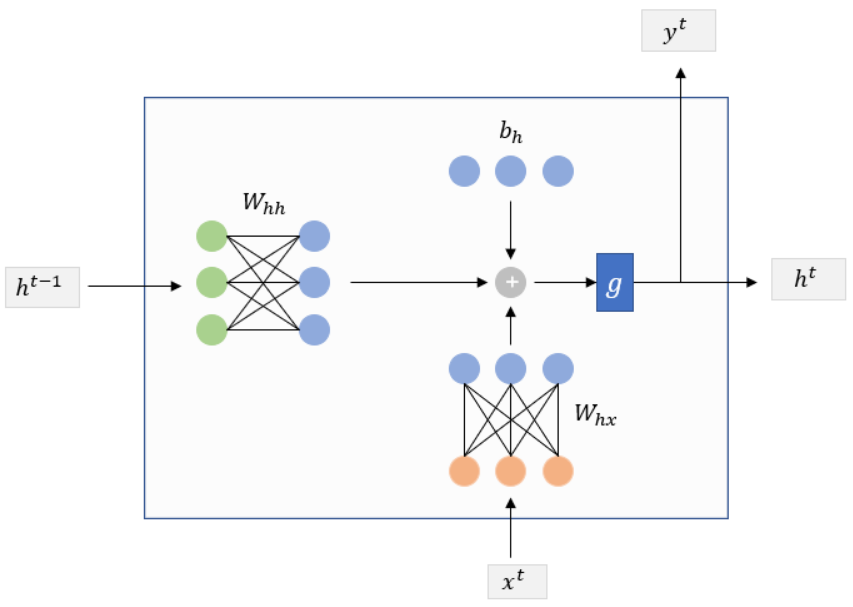



Por lo tanto, los pasos necesarios para actualizar nuestro estado oculto son los siguientes.



1.   Realizar producto punto del embedding de entrada con la matriz de pesos de la representación de entrada a la celda (`example_embedding_sequence[t] * w_hx`).
2.   Realizar producto punto entre el estado oculto anterior con la matriz de pesos recurrente (`hidden_state[t-1] * w_hh`).
3. Sumar los resultados de los pasos 1. y 2. con el sesgo.
4. Aplicar la función de activación.
5. Actualizar el estado oculto con el resultado de 4.



In [43]:
hidden_state = tf.zeros(128) # Inicializamos nuestro estado oculto con 0.
hidden_states =  [] # Acá acumularemos cada estado oculto con fines demostrativos.
w_hx = model_cwlce_trainable.layers[1].weights[0] # Esta es la matriz que representará nuestra entrada
w_hh = model_cwlce_trainable.layers[1].weights[1] # Esta es la matriz recurrente
b_h = model_cwlce_trainable.layers[1].weights[2] # Este es el bias

for x,unmasked in zip(example_embedding_sequence[0],example_input_mask[0]): # Iteramos por nuestra secuencia y las máscaras
  if unmasked: # Si no está enmascarado ese timestep actualizamos nuestro estado oculto
    hidden_state = tf.math.tanh( # Aplicamos la función de activación y actualizamos el estado oculto
        tf.tensordot(x,w_hx, axes=1) # Representamos el embedding de entrada
        + tf.tensordot(hidden_state,w_hh, axes=1) # Multiplicamos el estado oculto anterior con la matriz recurrente
        + b_h) # Sumamos el sesgo
    hidden_states.append(hidden_state) # Guardamos el estado oculto

example_representation = tf.expand_dims(hidden_state, axis=0) # La representación de nuestra secuencia es el último estado oculto
example_representation

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[-0.83903444,  0.24202631,  0.5311595 ,  0.03424908,  0.64748234,
        -0.11658559, -0.19237016,  0.68989396,  0.9168346 , -0.9991151 ,
        -0.91769546,  0.9127163 ,  0.4009017 ,  0.98331654, -0.936099  ,
         0.793386  , -0.14206703, -0.994173  ,  0.01225915,  0.61691153,
        -0.4016556 , -0.8498704 , -0.9876    ,  0.4831042 , -0.697212  ,
         0.72029877,  0.89762557,  0.8042045 ,  0.9647995 ,  0.38299668,
        -0.65496117,  0.3320116 , -0.8986515 ,  0.6692767 ,  0.9008471 ,
         0.94873494, -0.6437155 ,  0.07516085,  0.90036756, -0.96384686,
        -0.17431472, -0.921757  , -0.89003444, -0.42334235,  0.9696582 ,
        -0.33070162, -0.3448447 , -0.9310326 ,  0.5678185 , -0.68125904,
        -0.9834725 , -0.14463827,  0.8669711 ,  0.8390933 , -0.24855882,
        -0.56206644,  0.7728334 ,  0.5877565 , -0.8395774 ,  0.17632018,
         0.7973094 ,  0.78925914,  0.6285153 ,  0.4489446 ,  0.93859875,
 

Si visualizamos el cambio del estado oculto nos damos cuenta que cambió sólo debido sólo a los timestep desenmascarados y fue cambiando a medida que avanzamos en los pasos

<ipython-input-44-2084446146>:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


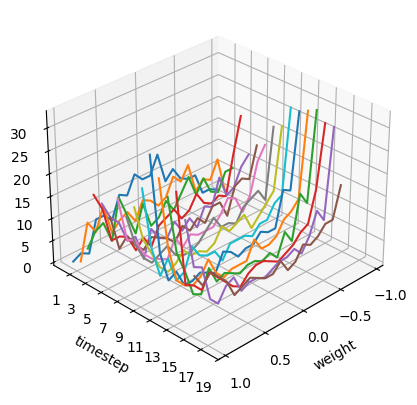

In [44]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

for z,t in enumerate(hidden_states):
  hist, bins = np.histogram(t, bins=20, range=(-1.0,1.0))
  xs = (bins[:-1] + bins[1:])/2
  ax.plot(
      xs,
      hist,
      z,
      zdir='y'
  )

ax.set_xlabel("weight")
ax.set_ylabel("timestep")
ax.set_zlabel("frequency")

plt.yticks(range(1,20,2))
plt.xticks(np.linspace(-1,1,5))

ax.view_init(30, 45)

plt.tight_layout()
plt.show()

Con la representación de nuestra secuencia podemos obtener la predicción final al realizar el producto punto entre la representación de la secuencia y los pesos de la capa de clasificación, junto con sumar el sesgo.

In [45]:
output = tf.math.sigmoid(# Aplicamos la función de activación
    tf.tensordot(example_representation,model_cwlce_trainable.layers[-1].weights[0], axes=1) # Hacemos producto punto entre la representación y los pesos
    + model_cwlce_trainable.layers[-1].weights[1]) # Sumamos el bias
output

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00100142]], dtype=float32)>

Si comparamos la salida de la red usando el método predict, nos damos cuenta que es el mismo valor que el calculado por nosotros.

In [46]:
model_cwlce_trainable.predict(example_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


array([[0.00100142]], dtype=float32)